In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import xgboost

from skopt import BayesSearchCV

In [2]:
train_df = pd.read_csv('./train.csv', index_col='id')

train_df

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


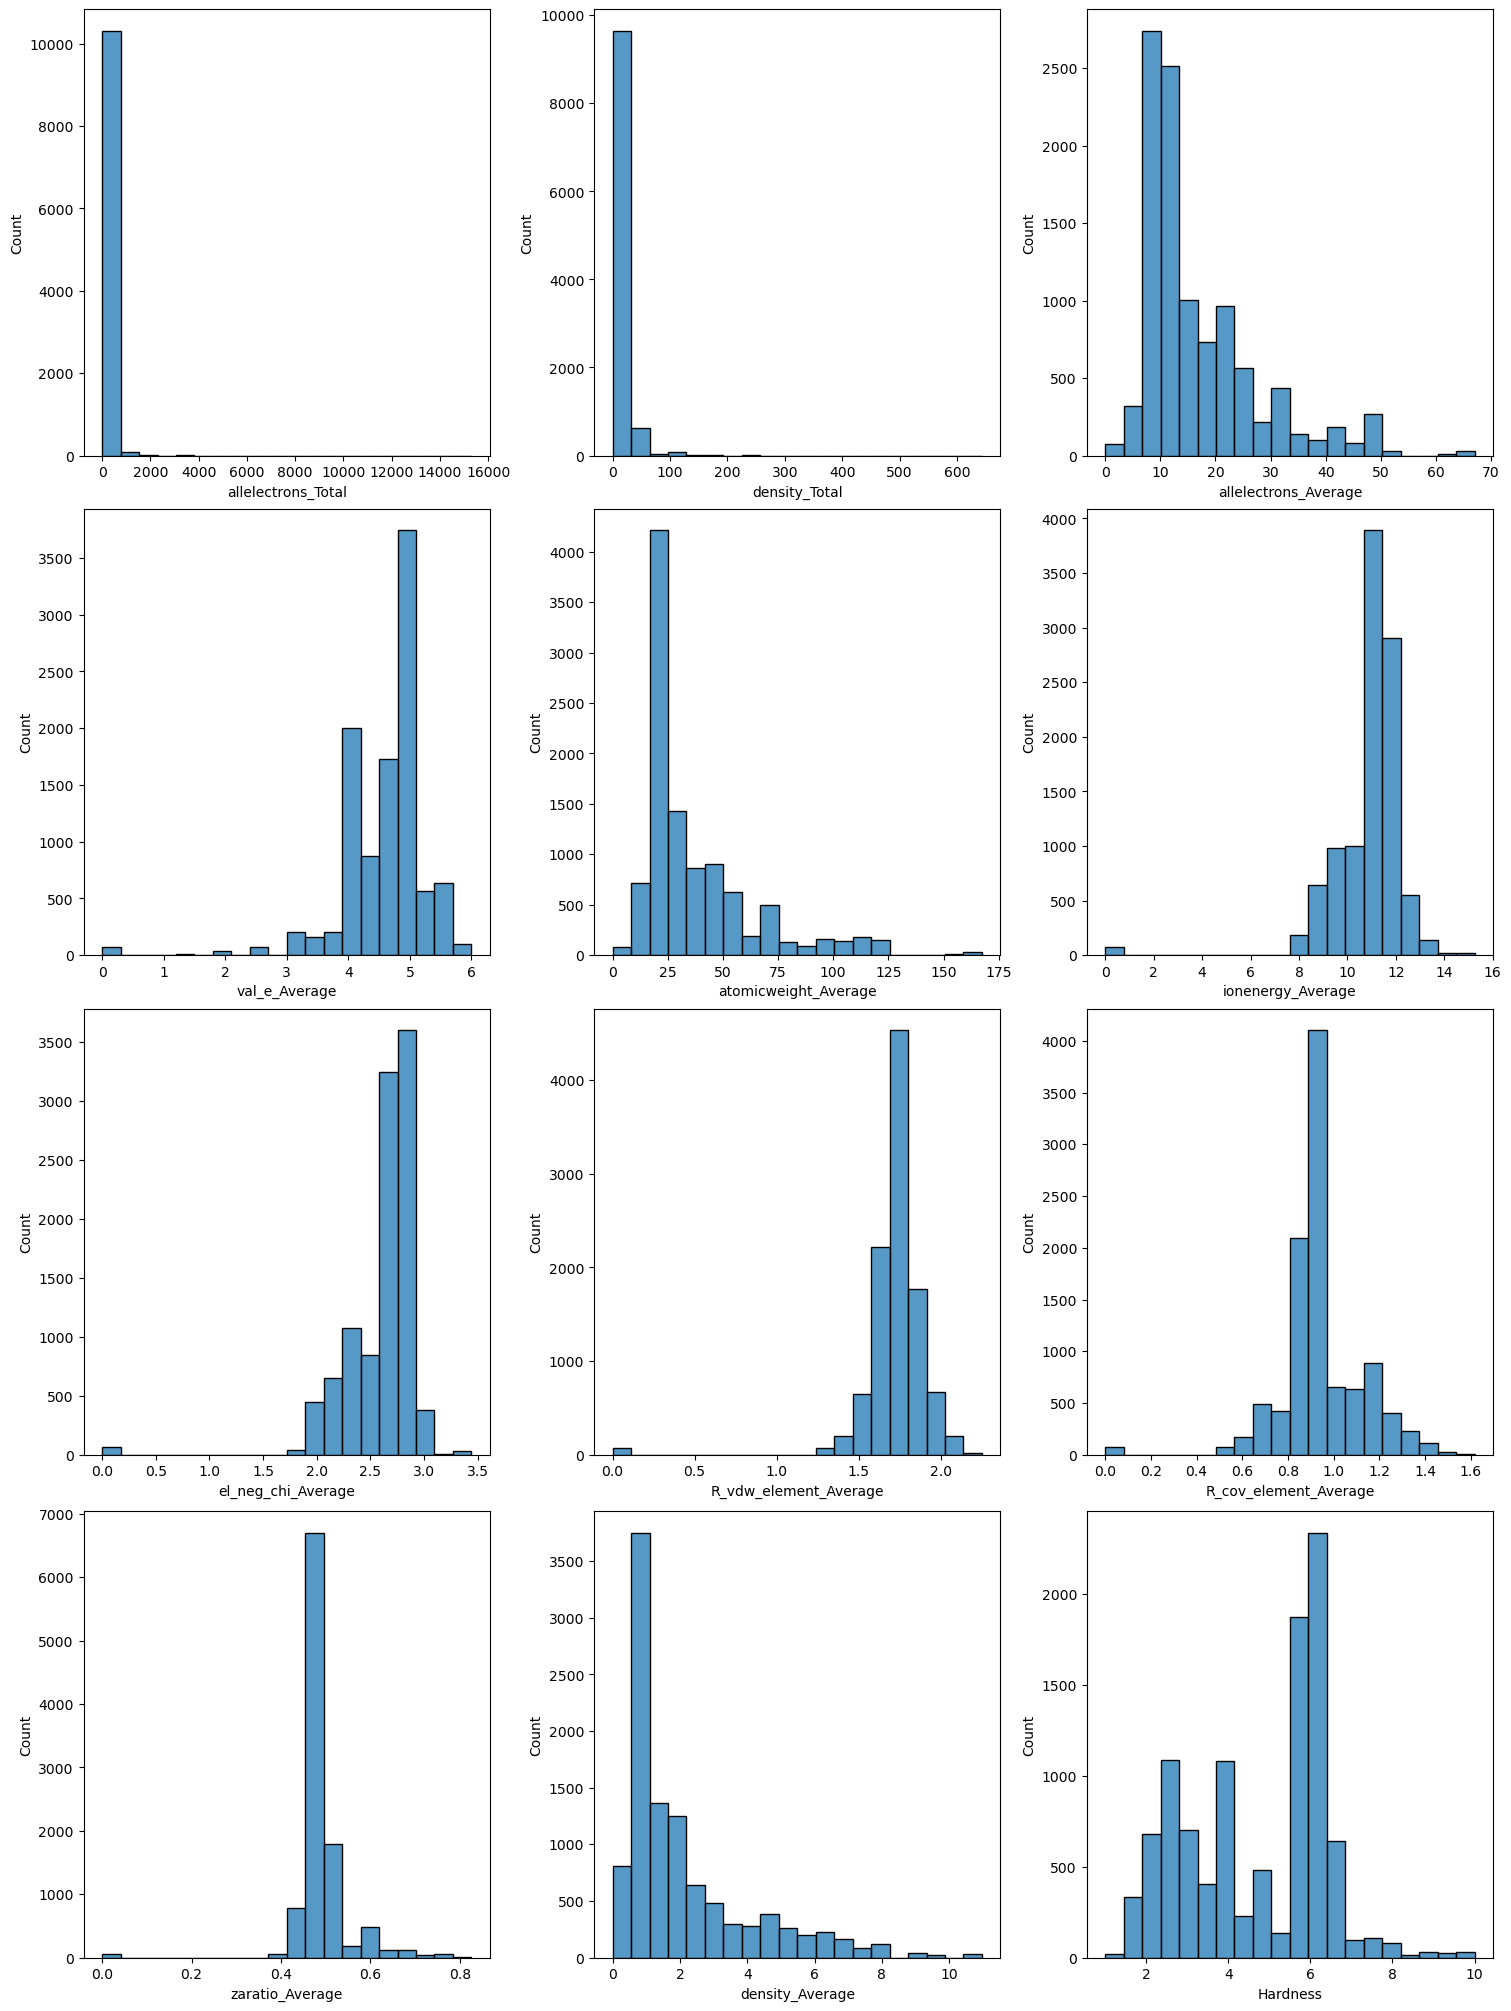

In [4]:
fig = plt.figure(layout='constrained')
fig.set_size_inches(15, 20)

for i, col in enumerate(train_df.columns, start=1):
    ax = fig.add_subplot(4, 3, i)
    sns.histplot(train_df, x=col, ax=ax, bins=20)

plt.show()

In [5]:
train_df.allelectrons_Average.corr(train_df.allelectrons_Total), train_df.density_Average.corr(train_df.density_Total)

(0.07472516374221048, 0.336046259996255)

In [6]:
# based on the categories
# compute the abs difference between the category and the hardness
# pick the index that is closest to 0

category_values = np.array([2, 2.5, 3, 3.5, 4, 4.8, 5.75, 6.4, 6.8])

category_idx = np.argmin(np.abs(train_df.Hardness.to_numpy().reshape(-1, 1) - category_values), axis=1)

train_df['HardnessCat'] = category_idx

In [7]:
eps = 1e-7

small_abs_error = 0
big_abs_error = 0

for cat, group in train_df[['Hardness', 'HardnessCat']].groupby('HardnessCat'):
    category_abs_error = (np.abs(group['Hardness'] - category_values[cat]) - 0.25 < eps).value_counts()
    small_abs_error += category_abs_error[True] if True in category_abs_error else 0
    big_abs_error += category_abs_error[False] if False in category_abs_error else 0

    print(f'Category: {category_values[cat]}')
    print(category_abs_error.values)

print('Total')
print(f'{small_abs_error}, {big_abs_error}')

Category: 2.0
[548 194]
Category: 2.5
[1382]
Category: 3.0
[703]
Category: 3.5
[406]
Category: 4.0
[1083  130]
Category: 4.8
[481  97]
Category: 5.75
[3939  136]
Category: 6.4
[674]
Category: 6.8
[338 296]
Total
9554, 853


In [8]:
y_col = 'HardnessCat'
y_col_temp = 'Hardness'
x_cols = train_df.columns.difference([y_col, y_col_temp])

x_train = train_df[x_cols]
y_train = train_df[y_col]

In [9]:
x_train

,R_cov_element_Average,R_vdw_element_Average,allelectrons_Average,allelectrons_Total,atomicweight_Average,density_Average,density_Total,el_neg_chi_Average,ionenergy_Average,val_e_Average,zaratio_Average
id,,,,,,,,,,,
0,0.860000,1.732000,10.000000,100.0,20.612526,0.91457,0.841611,2.766000,11.088100,4.800000,0.496070
1,0.910000,1.631000,10.000000,100.0,20.298893,0.71760,7.558488,2.755000,12.040830,4.800000,0.492719
2,0.864000,1.788000,15.600000,76.0,33.739258,1.50633,8.885992,2.828000,12.086300,5.600000,0.481478
3,0.936000,1.626000,10.000000,100.0,20.213349,0.78937,8.795296,2.648000,10.948500,4.800000,0.489272
4,0.896000,1.682000,11.600000,116.0,24.988133,1.86481,9.577996,2.766000,11.824480,4.800000,0.492736
...,...,...,...,...,...,...,...,...,...,...,...
10402,0.892000,1.631000,12.000000,128.0,26.385218,1.79607,7.558488,2.644000,11.330440,4.000000,0.496070
10403,0.866667,1.556667,10.000000,30.0,20.766935,0.81480,1.743160,3.090000,14.163933,5.333333,0.480390
10404,1.120000,1.545000,24.500000,196.0,53.490297,2.11540,30.920000,2.295000,10.074300,5.500000,0.469715


In [10]:
y_train

id
0        6
1        7
2        1
3        6
4        6
        ..
10402    4
10403    5
10404    0
10405    6
10406    7
Name: HardnessCat, Length: 10407, dtype: int64

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(shuffle=True, random_state=0)

search_params = {
    # 'booster': ['gbtree', 'dart'],
    'learning_rate': (0, 1),
    'gamma': (1e-6, 1e+6, 'log-uniform'),
    'max_depth': (2, 5),
    'min_child_weight': (1, 1e+6, 'log-uniform'),
    'reg_lambda': (1e-2, 1e+5, 'log-uniform'),
    'reg_alpha': (1e-2, 1e+5, 'log-uniform')
}

scorers = [
    accuracy_score,
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
]

clf = xgboost.XGBClassifier(n_estimators=50, subsample=0.5, random_state=0)
bsearch = BayesSearchCV(clf, search_params, cv=cv, refit=True, random_state=0, verbose=1)
bsearch.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_typ...
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=50, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=0, ...),
              random_state=0,
              search_spaces={'gamma': (1e-06, 1000000.0, 'log-uniform'),
                             'learning_rate': (0, 1), 'max_depth': (2, 5),
                             'min_child_weight': (1, 1000000.0, 'log-uniform'),
                             'reg_alpha': (0.01, 100000.0, 'log-uniform'),
                             'reg_lambda': (0.01, 100000.0, 'log-uniform')},
              verbose=1)

In [15]:
test_df = pd.read_csv('test.csv', index_col='id')
test_df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,,
10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [16]:
x_test = test_df[x_cols]
y_test = category_values[bsearch.predict(x_test)]

In [17]:
out_df = pd.DataFrame({'id': test_df.index, 'Hardness': y_test})
out_df.to_csv('out.csv', index=False)